# **AP157 Module C Lab Assignment**

## Module C2: Monte Carlo Methods

_Instructions_: Answer each part of the assignment as completely as you can. Discuss **all** your code and results as clearly and concisely as possible.

_Scoring Criteria_: 50% - *correctness of code*; 50% - *discussion of the code and results*. Maximum score is **100 points**.

_Credits_: This lab assignment is based on work by Dr. Reyes in collaboration with Gene Belinario and Dr. Reginald Bernardo.

### Student Information

_Full Name (Last Name, First Name)_: \
_Student No._:\
_Section_:

### Submission Information

_Date and Time Submitted (most recent upload)_:

**HONOR PLEDGE** I affirm that I have upheld the highest principles of honesty and integrity in my academic work and that this lab assignment is my own work.

**Sign here with your full name:**

### Grading Information (c/o Instructor)

TOTAL SCORE: **[]**/100

Score breakdown:
* Part 1 - []/20
* Part 2 - []/20
* Part 3 - []/30
* Part 4 - []/30

_Date and Time Scored (MM/DD/YYYY HH:MM AM/PM):_

In this lab assignment, you will generate constraints on cosmological parameters, the Hubble parameter H_0 and matter density Omega_m,0, from (synthetic) Hubble diagram data points from gravitational-wave (GW) sirens observed from 3 GW observatories: LIGO, LISA, and Einstein Telescope (ET).

The datasets are in the Google Drive "Datasets" Folder under "AP157_moduleC2" subfolder: https://drive.google.com/drive/folders/1UnK1AggxdsjtG3PoOcyXfpahBcWjOBzj?usp=drive_link.

Read in the 3 datasets from the CSV files: LIGO.csv, LISA.csv, ET.csv. The columns are redshift (z), luminosity distance (dL), and error in the luminosity distance (err). The distances are in units of Gpc (giga-parsecs).

Load the data into variable names: zLIGO, dLLIGO, errLIGO, zLISA, dLLISA, errLISA, and zET, dLET, and errET, respectively. Note that these variable names will be used in later parts of the code, so you have to use these names for compatibility.

In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
plt.rcParams["font.family"] = "Arial"

In [14]:
ligo_data = pd.read_csv('LIGO.csv')
lisa_data = pd.read_csv('LISA.csv')
et_data = pd.read_csv('ET.csv')

zLIGO, dlLIGO, errLIGO = ligo_data['zLIGO'], ligo_data['dlLIGO'], ligo_data['errLIGO']
zLISA, dlLISA, errLISA = lisa_data['zLISA'], lisa_data['dlLISA'], lisa_data['errLISA']
zET, dlET, errET = et_data['zET'], et_data['dlET'], et_data['errET']

By the end of the lab assignment, you will generate constraints on the cosmological parameters H_0 and omega_m,0 for 3 samples: LIGO only, LIGO+LISA, and LIGO+LISA+ET (combined). You will generate a corner plot to visualize these constraints similar to the figure here: https://drive.google.com/file/d/18H7GPlox4ijS9qFbk1rHo-NW5N_Nsfer/view?usp=drive_link

#### PART 1 - Generate Hubble Diagram *(20 points)*

Make a Hubble diagram plot-- with luminosity distance (d_L) in the vertical axis and redshift (z) in the horizontal axis. Show the errors in d_L as error bars.

Plot GW sirens from the 3 observatories in the same plot and include a legend. Briefly describe the difference between the samples from the 3 observatories.

We can plot the data like this:

Text(0.5, 1.05, 'Luminosity and redshift distance across observatories')

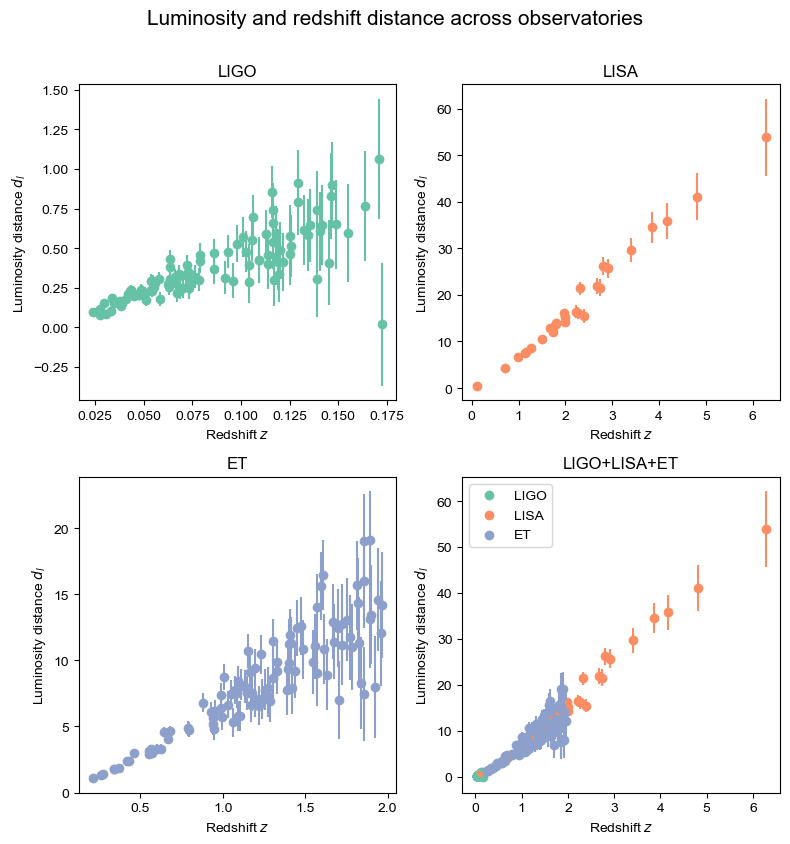

In [110]:
z_list = [zLIGO, zLISA, zET]
dl_list = [dlLIGO, dlLISA, dlET]
err_list = [errLIGO, errLISA, errET]
label_list = ['LIGO', 'LISA', 'ET']

plt.figure(figsize=(8, 8))

for i in range(4):
    if i == 3:
        plt.subplot(2, 2, 4)
        for i in range(3):
            plt.scatter(z_list[i], dl_list[i], label=label_list[i], color=sns.color_palette('Set2')[i])
            plt.errorbar(z_list[i], dl_list[i], yerr=err_list[i], fmt='.', color=sns.color_palette('Set2')[i])
        plt.xlabel(r'Redshift $z$')
        plt.ylabel(r'Luminosity distance $d_l$')
        plt.title('LIGO+LISA+ET')
        plt.legend()
    else:
        plt.subplot(2, 2, i+1)
        plt.scatter(z_list[i], dl_list[i], label=label_list[i], color=sns.color_palette('Set2')[i])
        plt.errorbar(z_list[i], dl_list[i], yerr=err_list[i], fmt='.', color=sns.color_palette('Set2')[i])
        plt.xlabel(r'Redshift $z$')
        plt.ylabel(r'Luminosity distance $d_l$')
        plt.title(label_list[i])

plt.tight_layout() # improves padding 
plt.suptitle('Luminosity and redshift distance across observatories', y=1.05, fontsize=15)

We see that the LIGO data doesn't vary as much as the ET data, as we still see the variance in the data even though the graph is zoomed out (shown in the LIGO+LISA+ET plot). On the other hand, LISA's data does not vary as much.

#### PART 2 - Define likelihood functions *(20 points)*

In this analysis, we will assume the cosmological model to be flat LambdaCDM universe. This is given by the `FlatLambdaCDM' model from the astropy.cosmology package. In particular, we use the model for the luminosity distance as a function of redshift, which is encoded in the luminosity_distance function.

Below, define the chi-square and likelihood function to be used for the LIGO only and the LIGO+LISA dataset. You are asked to define the analogous functions for the LIGO+LISA+ET dataset. Note that the likelihood for the combined dataset is simply the sum of the likelihoods for the individual datasets.




In [18]:
from astropy.cosmology import FlatLambdaCDM

In [19]:
def chi2LIGO_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)      # define cosmological model
    model = np.array(cosmo.luminosity_distance(zLIGO)/1000) # converted from Gpc to Mpc units
    dev = (model - np.array(dlLIGO))/np.array(errLIGO)      # deviations between model and data
    chi2 = sum(dev**2)
    return chi2

def llikeLIGO_lcdm(H0, Om0):
    if (H0 < 0) or (Om0 < 0):
        return -np.inf                        # return inf if outside priors
    else:
        return -0.5*chi2LIGO_lcdm(H0, Om0)

# LIGO + LISA
def chi2LISA_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)
    model = np.array(cosmo.luminosity_distance(zLISA)/1000)
    dev = (model - np.array(dlLISA))/np.array(errLISA)
    chi2 = sum(dev**2)
    return chi2

def llikeLIGOLISA_lcdm(H0, Om0):
    if (H0 < 0) or (Om0 < 0):
        return -np.inf
    else:
        return -0.5*(chi2LIGO_lcdm(H0, Om0) + chi2LISA_lcdm(H0, Om0))

# LIGO + LISA + ET
def chi2ET_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)
    model = np.array(cosmo.luminosity_distance(zET)/1000)
    dev = (model - np.array(dlET))/np.array(errET)
    chi2 = sum(dev**2)
    return chi2

def llikeLIGOLISAET_lcdm(H0, Om0):
    if (H0 < 0) or (Om0 < 0):
        return -np.inf
    else:
        return -0.5*(chi2LIGO_lcdm(H0, Om0) + chi2LISA_lcdm(H0, Om0) + chi2ET_lcdm(H0, Om0))

#### PART 3 - Perform MCMC runs *(30 points)*

Use the emcee library to set up and perform MCMC runs for the 3 samples: LIGO only, LIGO+LISA, and LIGO+LISA+ET combined.

You can use number of walkers (nwalkers) of 6 and number of iterations (niter) of 5,000 and number of burn-in samples (nburn) of 100.


In [42]:
import emcee as mc

n_walkers, n_iter, n_dim, n_burn = 6, 10000, 2, 100
step = [0.1, 0.003]
initial_true = [100, 0.1]
initials = [np.array(initial_true) + 1e-7*np.random.randn(2) for i in range(n_walkers)]

Since our ```llike``` functions all need 2 values, we need to convert them into a function that accepts only one.

In [43]:
def log_probability_ligo(x):
    return llikeLIGO_lcdm(x[0], x[1])

def log_probability_ligolisa(x):
    return llikeLIGOLISA_lcdm(x[0], x[1])

def log_probability_ligolisaet(x):
    return llikeLIGOLISAET_lcdm(x[0], x[1])

We then follow the [documentation](https://emcee.readthedocs.io/en/stable/tutorials/line/) of the ```emcee``` package on how to fit a model to data. However, since we have three observatories to get the data from, we have to do all of them.

In [55]:
def main(p0,nwalkers,niter,ndim,lnprob):
    sampler = mc.EnsembleSampler(nwalkers, ndim, lnprob)

    print("Burn-in for {lnprob}...".format(lnprob=lnprob))
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Production. for {lnprob}...".format(lnprob=lnprob))
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state
    
sampler_1, pos_1, prob_2, state_2 = main(initials,n_walkers,n_iter,n_dim, log_probability_ligo)
sampler_2, pos_2, prob_2, state_2 = main(initials,n_walkers,n_iter,n_dim, log_probability_ligolisa)
sampler_3, pos_3, prob_3, state_3 = main(initials,n_walkers,n_iter,n_dim, log_probability_ligolisaet)

Burn-in for <function log_probability_ligo at 0x00000176CB038E50>...
Production. for <function log_probability_ligo at 0x00000176CB038E50>...
Burn-in for <function log_probability_ligolisa at 0x00000176CB038790>...
Production. for <function log_probability_ligolisa at 0x00000176CB038790>...
Burn-in for <function log_probability_ligolisaet at 0x00000176CB038040>...
Production. for <function log_probability_ligolisaet at 0x00000176CB038040>...


Plotting the data, we get

Text(0.5, 1.05, 'Luminosity and redshift distance across observatories with walkers')

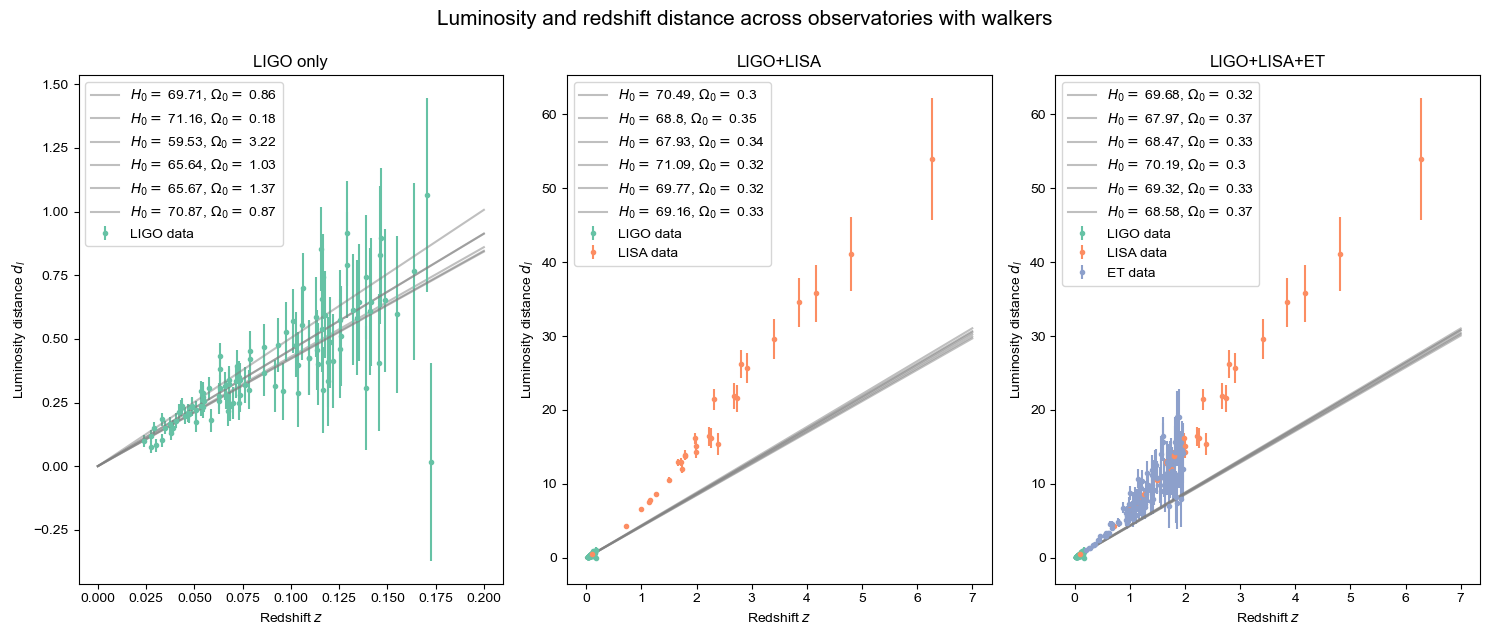

In [113]:
pos_list = [pos_1, pos_2, pos_3]
z_strs = ['zLIGO', 'zLISA','zET']
dl_strs = ['dlLIGO', 'dlLISA', 'dlET']
err_strs = ['errLIGO', 'errLISA', 'errET']
# data_list = [ligo_data, lisa_data, et_data]
label_list1 = ['LIGO only', 'LIGO+LISA', 'LIGO+LISA+ET']
array_list = [np.linspace(0, 0.0002, 2000), np.linspace(0, 0.007, 2000), np.linspace(0,.007,2000)]
colors = sns.color_palette('Set2')

const = 1000
plt.figure(figsize=(15, 6))
for walker in range(n_walkers):
    for observatory in range(3):
        # Constants and others
        H0, Om0 = pos_list[observatory][walker]
        cosmo_const = FlatLambdaCDM(H0, Om0, Tcmb0=2.725)
        model = np.array(cosmo_const.luminosity_distance(array_list[observatory]))

        # Plots
        plt.subplot(1, 3, observatory+1)
        plt.plot(array_list[observatory]*const, model, label=r'$H_0=$ {h0}, $\Omega_0=$ {om0}'.format(h0=np.round(H0, 2), om0=np.round(Om0, 2)), 
                 color='gray', alpha=0.5)
        plt.xlabel(r'Redshift $z$')
        plt.ylabel(r'Luminosity distance $d_l$')
        plt.legend()
        plt.title(label_list1[observatory])

        # Errors
        if walker==0 and observatory==0:
            plt.errorbar(zLIGO.values/1000*const, dlLIGO.values, yerr=errLIGO, label='LIGO data', fmt=".", color=colors[0])
        elif walker==0 and observatory==1:
            plt.errorbar(zLIGO.values/1000*const, dlLIGO.values, yerr=errLIGO, label='LIGO data', fmt=".", color=colors[0])
            plt.errorbar(zLISA.values/1000*const, dlLISA.values, yerr=errLISA, label='LISA data', fmt=".", color=colors[1])
        elif walker==0 and observatory==2:
            plt.errorbar(zLIGO.values/1000*const, dlLIGO.values, yerr=errLIGO, label='LIGO data', fmt=".", color=colors[0])
            plt.errorbar(zLISA.values/1000*const, dlLISA.values, yerr=errLISA, label='LISA data', fmt=".", color=colors[1]) 
            plt.errorbar(zET.values/1000*const, dlET.values, yerr=errET, label='ET data', fmt=".", color=colors[2])

plt.tight_layout() # improves padding 
plt.suptitle('Luminosity and redshift distance across observatories with walkers', y=1.05, fontsize=15)

Here we see the luminosity and redshift distance across observatories with the MCMC walkers. The walkers for the data in LIGO only closely resembles the data, however, we see that the walkers in LIGO+LISA and LIGO+LISA+ET diverged from the data. This is probably due to the fact that their $\Omega_0$ are all of the same magnitude (all in the ballpark of 0.3). 

#### PART 4 - Generate corner plot to visualize the constraints *(30 points)*

Overlay the results for the 3 samples for easy comparison. Your plot should resemble the figure here: https://drive.google.com/file/d/18H7GPlox4ijS9qFbk1rHo-NW5N_Nsfer/view?usp=drive_link

Briefly describe the difference between the constraints obtained from the different samples.

Text(0.5, 1.05, 'Corner plot of the data')

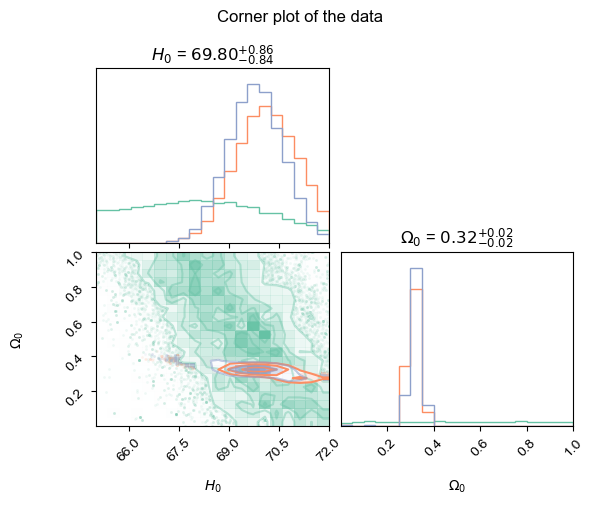

In [114]:
import corner

sample_list = [sampler_1, sampler_2, sampler_3]
labels = ['$H_0$','$\Omega_0$']

fig = plt.figure()
for i, sample in enumerate(sample_list):
    samples = sample.flatchain
    corner.corner(data=samples,fig=fig,labels=labels,show_titles=True, plot_datapoints=True, color=colors[i], range=[(65,72),(0,1)])
plt.suptitle('Corner plot of the data', y=1.05)

Here we depict the lines as teal for LIGO, orange for LIGO+LISA, and mauve for LIGO+LISA+ET. We see in the corner plots that the LIGO data was not constrained at all to a specific range in $H_0$. This is probably due to the randomness of the walkers.